<a href="https://colab.research.google.com/github/eireford/ConwayLifeTensorFlow/blob/master/LTF_heuristic_on_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Life on TensorFlow 
##Heuristic Life algorithm on tpu

This attempt to run Heuristic Life on tpu seems to run but does not appears not to be utilizing the tpu.

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time
import numpy as np
import scipy.signal
import timeit

In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.63.13.146:8470
INFO:tensorflow:Initializing the TPU system: 10.63.13.146:8470


INFO:tensorflow:Initializing the TPU system: 10.63.13.146:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [4]:
default_grid_shape = [2048,2048]

def random_uniform_grid(shape=default_grid_shape):
  return tf.round(tf.random.uniform(shape=shape,dtype=tf.float32))

X_COMMON = random_uniform_grid()

alive_total = tf.reduce_sum(X_COMMON)
alive_ratio = alive_total/(X_COMMON.shape[0]*X_COMMON.shape[1])
print(f"living cells: {int(alive_total):,.0f} {alive_ratio:.3%}")
#expect ~50% alive

living cells: 2,097,820 50.016%


In [0]:
def convolve_for_density_map(X):
  livable_kernal = tf.constant([[[[1]],[[1]],[[1]]],
                                   [[[1]],[[10]],[[1]]],
                                   [[[1]],[[1]],[[1]]]],dtype=tf.float32)
  X_reshaped = tf.reshape(X,[1,X.shape[0],X.shape[1],1])
  denisty_map = tf.reshape(tf.nn.conv2d(X_reshaped,livable_kernal,[1,1,1,1],"SAME"),X.shape)
  return denisty_map 

def will_be_alive(density_map):
  is_three = tf.equal(density_map,3.0)
  is_twelve = tf.equal(density_map,12.0)
  is_thirteen = tf.equal(density_map,13.0)
  any_true = is_three | is_twelve | is_thirteen
  return tf.cast(any_true,dtype=tf.float32)

def run(X,steps): 
  for i in range(steps):
    density_map = convolve_for_density_map(X)
    X = will_be_alive(density_map)
  return X

def run_cpu(steps):
  with tf.device('/CPU:0'):
    return run(X_COMMON,steps)

def run_tpu(steps):
  with strategy.scope():
    return run(X_COMMON,steps)    

In [6]:
%time Y_tpu = run_tpu(1000)

CPU times: user 4.1 s, sys: 1.26 s, total: 5.36 s
Wall time: 14 s


In [7]:
%time Y_cpu = run_cpu(1000)

CPU times: user 3.92 s, sys: 1.31 s, total: 5.24 s
Wall time: 13.8 s


In [8]:
%time Y_tpu = run_tpu(10000)

CPU times: user 40.1 s, sys: 13.5 s, total: 53.6 s
Wall time: 2min 19s


In [9]:
%time Y_cpu = run_cpu(10000)

CPU times: user 39.7 s, sys: 13.3 s, total: 53.1 s
Wall time: 2min 18s


In [0]:
assert(np.array_equal(Y_cpu,Y_tpu))

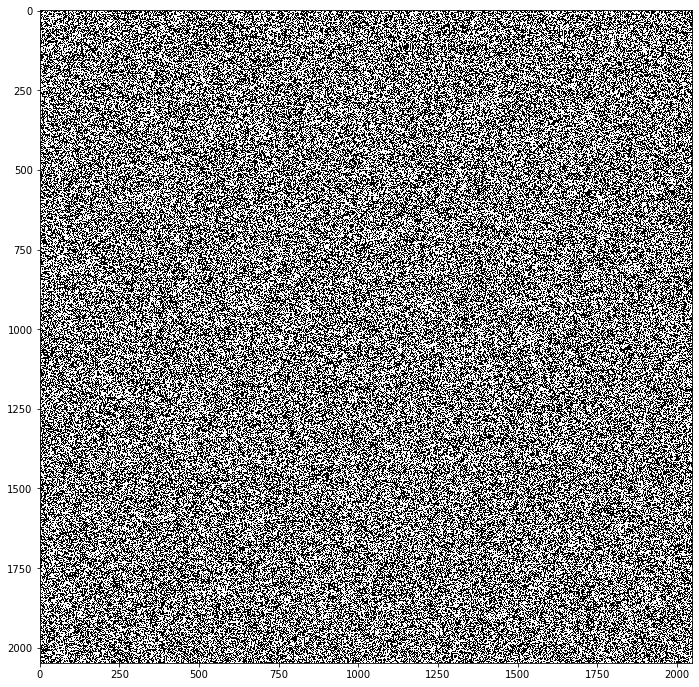

In [11]:
plt.gcf().set_size_inches(12,12)
figure_1 = plt.imshow(X_COMMON,cmap='Greys',origin='upper',interpolation='nearest')

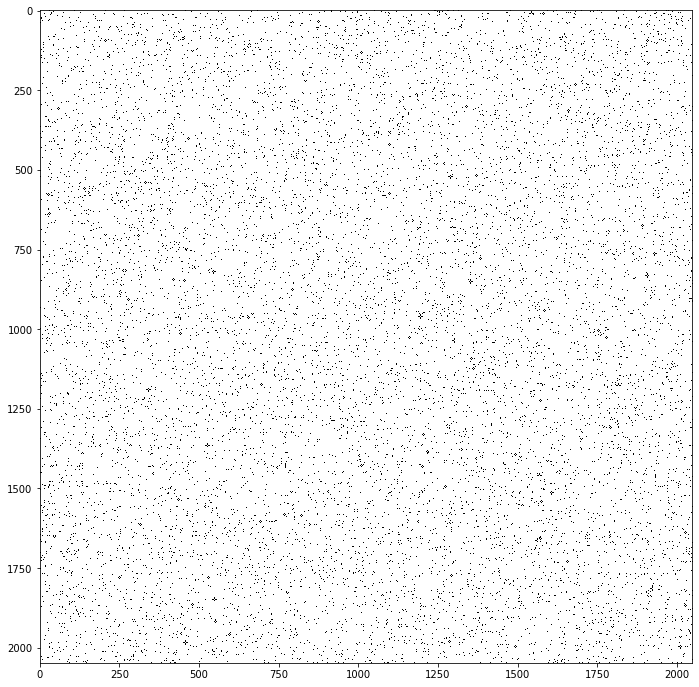

In [12]:
plt.gcf().set_size_inches(12,12)
figure_1 = plt.imshow(Y_tpu,cmap='Greys',origin='upper',interpolation='nearest')